## Calculation of Scoring

The scoring $S_{ijk}$ is a value that multiplies each variable $X_{ijk}$ in order to increase or decrease the probability of being included in the model.

>$S_{ijk}$: scoring applied to vehicle type $i$ at station $j$ and during shift $k$. Each value of $S_{ijk}$ is calculated as follows:

$S_{ijk} = P_{NearbyNeighborhoods_j}*S_{NearbyNeighborhoods_j} + P_{Density_j}*S_{Density_j} + P_{Capacity_j}*S_{Capacity_j} + P_{NearbyStations_j}*S_{NearbyStations_j} + P_{ShiftIncidents_k}*S_{ShiftIncidents_k} + P_{Vehicle_{i,k}}*S_{Vehicle_{i,k}}$.

$S_{ijk} \geq{0};\ S_{ijk} \in \mathbb{R} ;\ S_{ijk} \in [0,1]$

---

Where $P_{x}$ is the weight associated with each scoring $S_{x}$. The values of $P_{x}$ are in the range of `[0,1]`. These weights will be as follows:

- $P_{NearbyNeighborhoods_j} = 0.25$
- $P_{Density_j} = 0.05$
- $P_{Capacity_j} = 0.15$
- $P_{NearbyStations_j} = 0.2$
- $P_{ShiftIncidents_k} = 0.25$
- $P_{Vehicle_{i,k}} = 0.1$

Where $\Sigma_{x=1}^6 P_{x}=1, x \in \{NearbyNeighborhoods_j, Density_j, Capacity_j, NearbyStations_j, ShiftIncidents_k, Vehicle_{i,k}\}$

---

On the other hand, the application with the model variables, would be as follows:

$maxZ = S_{1,1,1}*X_{1,1,1} + S_{2,1,1}*X_{2,1,1} + S_{3,1,1}*X_{3,1,1} + S_{4,1,1}*X_{4,1,1} + S_{5,1,1}*X_{5,1,1} + S_{1,1,2}*X_{1,1,2} + S_{2,1,2}*X_{2,1,2} + S_{3,1,2}*X_{3,1,2} + S_{4,1,2}*X_{4,1,2} + S_{5,1,2}*X_{5,1,2} + ... + S_{5,218,2}*X_{5,218,2} $

In this way, we would have 10 different scorings for each station, 5 for each shift, each one for a type of vehicle per shift.


## Libraries

In [ ]:
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [ ]:
def load_json(lista_urls):
    """Load the json from the URL.
    - list_urls (list): list of URLs with the json to download.
    Returns a list with the generated json.
    """
    return (json.loads(requests.get(url).text) for url in lista_urls)

def create_dic_density(neighborhoods):
    """Create a dictionary with densities of all neighborhoods.
    - neighborhoods (json): json of neighborhoods.
    Returns a dictionary with neighborhood id as the key and density as the value.
    """
    dic_density = {} # density dictionary
    for b in neighborhoods:
        dic_density[b['nta']] = round( (b['population'] / b['shape_area'])*100 , 5)
    return dic_density

def create_dic_incid(incidents):
    """Calculate a dictionary of incidents by neighborhood.
    - incidents (json): json of incidents.
    Returns a dictionary of incidents.
    """
    dic_incid = {} # incidents dictionary.
    for i in incidents:
        barri = i['nta'] # "Neighborhood of the incident"
        if barri not in dic_incid:
            dic_incid[barri] = {} # dict within each Neighborhood
            # count of indicidents in each Neighborhood
            dic_incid[barri]['noche'] = {'num_incid': 0}
            dic_incid[barri]['dia'] = {'num_incid': 0}
        turno = 'noche' # night
        if i['is_first_shift'] == False: # day
            turno = 'dia'

        dic_incid[barri][turno]['num_incid'] += 1 # increase the counter

        incid_pos = dic_incid[barri][turno]['num_incid']
        # take the incident value and use it to create a list of vehicle types
        # each position in the list represents a type of vehicle.
        dic_incid[barri][turno][f'incidente_{incid_pos}'] = [0,0,0,0,0]

        units = i['units'] # store types of vehicle involved in the incident
        for u in set(units): # use set to get unique values
            # store values for each type of vehicle per incident
            if u == 'engine':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][0] += units.count(u)
            elif u == 'ladder':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][1] += units.count(u)
            elif u == 'rescue':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][2] += units.count(u)
            elif u == 'squad':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][3] += units.count(u)
            elif u == 'hazardous':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][4] += units.count(u)
    return dic_incid

def create_dic_stations(stations, dist_est_barrios, dic_density, dic_incid, dist_est):
    """Calculate the scores of each type for each of the stations.
    - stations (json): json of stations.
    - dist_est_barrios (json): json of distances from stations to neighborhoods.
    - dic_density (dict): precalculated dictionary of densities by neighborhood.
    - dic_incid (dict): precalculated dictionary of incidents by neighborhood.
    - dist_est (json): json of distances between stations.
    Returns each of the scores (8), the dictionary of stations, and a list
    with the names of each station.
    """
    dic_ests  = {} # stations dictionary
    n_est = [] # names of stations
    bc, dens, i_noc, i_dia, v_noc, v_dia, caps, ec = [],[],[],[],[],[],[],[]

    for i in stations:
        ### STATION NAME
        dir = i['address']
        dic_ests[dir] = {}

        n_est.append(dir)

        ### NEARBY NEIGHBORHOODS (<= 780 segs)
        dic_ests[dir]['barrios_cercanos'] = {}
        for b,d in dist_est_barrios[dir].items():
            if d <= 780: # Less than this distance, some neighborhoods are not included
                dic_ests[dir]['barrios_cercanos'][b] = [d]

        bc.append(len(dic_ests[dir]['barrios_cercanos']))

        ### STATION NEIGHBORHOOD WITH NAME, DISTANCE AND DENSITY
        dist, barrio = min((v[0],k) for k,v in dic_ests[dir]['barrios_cercanos'].items())
        dic_ests[dir]['barrio'] = [barrio, dist, dic_density[barrio]]

        dens.append(dic_density[barrio])

        ### INCIDENTS IN NEARBY NEIGHBORHOODS
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
            if b in dic_incid.keys():
              d.append(dic_incid[b])
            else:
              d.append({})

        ### MAXIMUM DAYTIME AND NIGHTTIME INDICENTS IN A NEIGHBORHOOD
        incid_mean_noche, incid_mean_dia = [],[]
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
          if d[1] != {}:
              if d[1]['noche'] != {}: # nighttime
                  incid_mean_noche.append((d[1]['noche']['num_incid'], b))
              else:
                  incid_mean_noche.append((0, b))
              if d[1]['dia'] != {}: # daytime
                  incid_mean_dia.append((d[1]['dia']['num_incid'], b))
              else:
                  incid_mean_dia.append((0, b))
          else:
              incid_mean_noche.append((0, b))
              incid_mean_dia.append((0, b))

        incid_mean_noche = int(np.mean([x[0] for x in incid_mean_noche]))
        incid_mean_dia = int(np.mean([x[0] for x in incid_mean_dia]))

        dic_ests[dir]['incidentes_max'] = {'noche': incid_mean_noche,
                                          'dia': incid_mean_dia }

        i_noc.append(incid_mean_noche)
        i_dia.append(incid_mean_dia)

        ### KIND OF VEHICLES BY INCIDENTS
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
          if d[1] != {}:
              mean_vh_noche = np.mean(np.array([ v if (k != 'num_incid' and d[1]['noche'] is not None) else [0,0,0,0,0]
                                                          for k,v in d[1]['noche'].items() ]), axis=0)
              mean_vh_dia = np.mean(np.array([ v if (k != 'num_incid' and d[1]['dia'] is not None) else [0,0,0,0,0]
                                                          for k,v in d[1]['dia'].items() ]), axis=0)
          else:
              continue
          dic_ests[dir]['media_tipo_vhs'] = {
                  'noche': list(mean_vh_noche),
                  'dia': list(mean_vh_dia)
              }

        v_noc.append(list(mean_vh_noche))
        v_dia.append(list(mean_vh_dia))

        ### STATION CAPACITY
        dic_ests[dir]['capacidad'] = i['capacity']

        caps.append(dic_ests[dir]['capacidad'])

        ### NEARBY STATIONS (<= 700 seg)
        dic_ests[dir]['estaciones_cercanas'] = []
        for e,d in dist_est[dir].items():
            if d <= 700: # Less than this distance, some neighborhoods are not included
                dic_ests[dir]['estaciones_cercanas'].append((e,d))

        ec.append(len(dic_ests[dir]['estaciones_cercanas']))

    return bc, dens, i_noc, i_dia, caps, ec, v_noc, v_dia, dic_ests, n_est

### NORMALIZE SCORES FOR UNIQUE VALUES
def normalize_list(numbers):
    """Applies a min-max normalization to the single-value scores.
    - numbers (list): list of scores for each station with unique values
    Returns the list of normalized scores.
    """
    min_val = min(numbers)
    max_val = max(numbers)
    normalized = [(x - min_val) / (max_val - min_val) for x in numbers]
    return normalized

### INVERSE NORMALIZATION OF SCORES FOR UNIQUE VALUES (nearby stations and capacity)
def normalize_list_invers(numbers):
    """Applies a min-max normalization to single-value scores that have
    an inverse relationship (nearby stations and capacity).
    - numbers (list): list of scores for each station with unique values
    Returns the list of normalized scores.
    """
    min_val = min(numbers)
    max_val = max(numbers)
    normalized = [1-((x - min_val) / (max_val - min_val)) for x in numbers]
    return normalized

### NORMALIZE SCORES FOR VALUES IN LISTS (kind of vehicle)
def normalize_list_of_lists(list_of_lists):
    """Applies a min-max normalization to the grouped scores.
    - list_of_lists (list): list of lists of scores with grouped values,
    which in this case are the types of vehicles. Each list of lists has
    5 values.
    Returns a list of lists with the normalized scores.
    """
    normalized_list_of_lists = []
    for sublist in list_of_lists:
        if all(sublist) == False:
            normalized_sublist = [0.2]*5
        else:
            min_val = min(sublist)
            max_val = max(sublist)
            normalized_sublist = [1-((x - min_val) / (max_val - min_val)) for x in sublist]
        normalized_list_of_lists.append(normalized_sublist)
    return normalized_list_of_lists

### GENERATE A LIST OF NORMALIZED SCORES AND SORT IT
def scores_norm(l_scores_1, l_scores_2):
    """Combines the two types of scores into a single list.
    - l_scores_1 (list): list of normalized single-value scores.
    - l_scores_2 (list): list of lists of normalized grouped scores.
    Returns a list with all the normalized scores.
    """
    list_scores_norm = []
    for i,l in enumerate(l_scores_1):
        if i == 4 or i == 5:
            list_scores_norm.append(normalize_list_invers(l))
        else:
            list_scores_norm.append(normalize_list(l))
    for l in l_scores_2:
        list_scores_norm.append(normalize_list_of_lists(l))
    return list_scores_norm

### ADD SCORES TO EACH STATION
def add_scores_to_station(n_est, dic_estaciones, list_scores_norm):
    """Adds the scorings to the stations dictionary, creating a structure
    suitable for the next process.
    - n_est (list): list of station names.
    - dic_estaciones (dict): stations dictionary.
    - list_scores_norm (list): list of normalized scores
    Returns the stations dictionary with the scorings for each station.
    """
    dic_ests = dic_estaciones.copy()
    for e in range(len(n_est)):
        dic_ests[n_est[e]]['scorings'] = {
            'num_barrios_cerca': list_scores_norm[0][e],
            'densidad': list_scores_norm[1][e],
            'mean_incids_noche': list_scores_norm[2][e],
            'mean_incids_dia': list_scores_norm[3][e],
            'capacidad': list_scores_norm[4][e],
            'num_estaciones_cerca': list_scores_norm[5][e],
            'vhs_1_noche': list_scores_norm[6][e][0],
            'vhs_2_noche': list_scores_norm[6][e][1],
            'vhs_3_noche': list_scores_norm[6][e][2],
            'vhs_4_noche': list_scores_norm[6][e][3],
            'vhs_5_noche': list_scores_norm[6][e][4],
            'vhs_1_dia': list_scores_norm[7][e][0],
            'vhs_2_dia': list_scores_norm[7][e][1],
            'vhs_3_dia': list_scores_norm[7][e][2],
            'vhs_4_dia': list_scores_norm[7][e][3],
            'vhs_5_dia': list_scores_norm[7][e][4]
        }
    return dic_ests

def calculate_general_scoring(dic_ests, importancias):
    """Multiplies each score by its associated importance and sums up the values,
    generating the 10 corresponding scores for each station: 5 for the day shift
    and 5 for the night shift.
    - dic_ests (dict): dictionary of stations with the scorings included.
    - importancias (dict): dictionary with the importances for each type of scoring.
    Returns a dictionary with the resulting scorings unnormalized.
    """
    resultados = {}
    for nombre, datos in dic_ests.items():
        scorings = datos['scorings']
        scoring_noche = []

        for i in range(5):
          # Nighttime Scoring
            s_noche = (
                scorings['num_barrios_cerca'] * importancias['num_barrios_cerca'] +
                scorings['densidad'] * importancias['densidad'] +
                scorings['mean_incids_noche'] * importancias['mean_incids_noche'] +
                scorings['capacidad'] * importancias['capacidad'] +
                scorings['num_estaciones_cerca'] * importancias['num_estaciones_cerca'] +
                scorings[f'vhs_{i+1}_noche'] * importancias[f'vhs_{i+1}_noche']
            )
            scoring_noche.append(s_noche)

        scoring_dia = []

        # Daytime Scoring
        for i in range(5):
            s_dia = (
                scorings['num_barrios_cerca'] * importancias['num_barrios_cerca'] +
                scorings['densidad'] * importancias['densidad'] +
                scorings['mean_incids_dia'] * importancias['mean_incids_dia'] +
                scorings['capacidad'] * importancias['capacidad'] +
                scorings['num_estaciones_cerca'] * importancias['num_estaciones_cerca'] +
                scorings[f'vhs_{i+1}_dia'] * importancias[f'vhs_{i+1}_dia']
            )
            scoring_dia.append(s_dia)

        resultados[nombre] = {'scoring_noche': scoring_noche, 'scoring_dia': scoring_dia}
    return resultados

def mix_max_scores(results):
    """Calculates the minimums and maximums of the scorings for all stations.
    - results (dict): dictionary with the 10 weighted scorings for each
    station in the night and day shifts.
    Returns the minimum and maximum scoring values for night and day.
    """
    min_noche = min( min(list(v.values())[0]) for v in results.values() )
    max_noche = max( max(list(v.values())[0]) for v in results.values() )
    min_dia = min( min(list(v.values())[1]) for v in results.values() )
    max_dia = max( max(list(v.values())[1]) for v in results.values() )
    return min_noche, max_noche, min_dia, max_dia

def normalize_score_and_weights( min_noche, max_noche, min_dia, max_dia, results):
    """Calculates the minimums and maximums of the scorings for all stations.
    - min_noche (int): minimum value of the scorings for the night shift.
    - max_noche (int): maximum value of the scorings for the night shift.
    - min_dia (int): minimum value of the scorings for the day shift.
    - max_dia (int): maximum value of the scorings for the day shift.
    - results (dict): dictionary with the 10 weighted scorings for each
    station in the night and day shifts.
    Returns the same results dictionary received, but with the scorings
    normalized using a min-max normalization.
    """
    for nombre, datos in results.items():
        for i in range(5):
            scoring_noche = datos['scoring_noche'][i]
            scoring_dia = datos['scoring_dia'][i]

            results[nombre]['scoring_noche'][i] = (scoring_noche - min_noche) / (max_noche - min_noche)
            results[nombre]['scoring_dia'][i] = (scoring_dia - min_dia) / (max_dia - min_dia)

    return results

def create_final_scores(general_scorings, estaciones):
    """Creates the final dictionary of scores for each type of vehicle, for each
    station and for each shift (10).
    - general_scorings (dict): dictionary with 10 scorings for day and night.
    - estaciones (json): json of stations.
    Returns a dictionary with the 10 scores for each station with a tuple i,j,k
    as the key and its corresponding score as the value.
    """
    scores = {}
    for i,e in enumerate(estaciones):
        for pos in range(5):
            scores[(pos+1,i+1,1)] = general_scorings[e['address']]['scoring_noche'][pos]
            scores[(pos+1,i+1,2)] = general_scorings[e['address']]['scoring_dia'][pos]
    return scores

def print_score_station(estaciones, num_est):
    """Displays all scores associated with a station on the screen.
    - num_est (int): id associated with each station.
    - estaciones (json): json of stations.
    """
    for i,e in enumerate(estaciones):
        if i+1 == num_est:
            print(f'ESTACIÓN: {e["address"]}\n')
            for x in range(5):
                print(f'S{x+1,i+1,1} = {scores[(x+1,i+1,1)]:.3f}')
                print(f'S{x+1,i+1,2} = {scores[(x+1,i+1,2)]:.3f}')

def print_valores_scores(estaciones):
    """Displays on the screen the maximum and minimum values of all the scores,
    as well as the maximum and minimum values of the mean and median. This allows
    us to see the structure of the distribution.
    - estaciones (json): json of stations.
    Returns minimum and maximum limits, mean, and median.
    """
    lmin, lmax, mean, median = [], [], [], []
    for i,e in enumerate(estaciones):
        list_scores_est = []
        for x in range(5):
          for a in range(2):
              list_scores_est.append(scores[(x+1,i+1,a+1)])
        lmin.append( min(list_scores_est) )
        lmax.append( max(list_scores_est) )
        mean.append( np.mean(list_scores_est) )
        median.append( np.median(list_scores_est) )
    return lmin, lmax, mean, median

def total_scores(estaciones):
    """Adds all the scores to a list to visualize the distribution.
    - estaciones (json): json of stations.
    Returns a list with the 2190 scores generated.
    """
    l_tot = []
    for i,e in enumerate(estaciones):
        for x in range(5):
          for a in range(2):
              l_tot.append(scores[(x+1,i+1,a+1)])
    return l_tot

## Generación de Scores

In [ ]:
list_urls = [
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones_barrios.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/estaciones.json"
]

# jsons with the necessary information to create the scorings
incidents, dist_est_neigh, dist_station, neighbors, stations = load_json(list_urls)

# precalculated dictionary of neighborhood densities
dic_density = create_dic_density(neighbors)

# precalculated dictionary of incidents
dic_incid = create_dic_incid(incidents)

# dictionary of stations with all relevant information
result = create_dic_stations(stations, dist_est_neigh, dic_density, dic_incid, dist_station)

# put single-value scores in one list and grouped scores in another
list_scores_1 = [result[0],result[1],result[2],result[3],result[4],result[5]]
list_scores_2 = [result[6],result[7]]

# list of normalized scores
list_scores_norm = scores_norm(list_scores_1, list_scores_2)

# dictionary of stations with scores
dic_stations = add_scores_to_station(result[9], result[8], list_scores_norm)

# define the importances of each scoring
importances = {
    'num_barrios_cerca': 0.25, 'densidad': 0.05, 'mean_incids_noche': 0.25,
    'mean_incids_dia': 0.25, 'capacidad': 0.15, 'num_estaciones_cerca': 0.2,
    'vhs_1_noche': 0.1, 'vhs_2_noche': 0.1, 'vhs_3_noche': 0.1,
    'vhs_4_noche': 0.1, 'vhs_5_noche': 0.1, 'vhs_1_dia': 0.1,
    'vhs_2_dia': 0.1, 'vhs_3_dia': 0.1, 'vhs_4_dia': 0.1,
    'vhs_5_dia': 0.1 }

# calculate scores with associated weights
results = calculate_general_scoring(dic_stations, importances)

# min and max of day and night for all scores
min_night, max_night, min_day, max_day = mix_max_scores(results)

# calculation of normalized scorings at a general level
general_scores = normalize_score_and_weights(min_night,max_night,min_day,max_day,results)

# generate the final scores for each station, type of vehicle and shift
scores = create_final_scores(general_scores, stations)

In [ ]:
### EXAMPLE OF SCORES WITH STATION 143
print_score_station(stations, 143)

ESTACIÓN: 1851 E. 48 Street

S(1, 143, 1) = 0.545
S(1, 143, 2) = 0.443
S(2, 143, 1) = 0.504
S(2, 143, 2) = 0.443
S(3, 143, 1) = 0.728
S(3, 143, 2) = 0.443
S(4, 143, 1) = 0.738
S(4, 143, 2) = 0.443
S(5, 143, 1) = 0.738
S(5, 143, 2) = 0.443


In [ ]:
### DISTRIBUTION OF SCORES
lmin, lmax, mean, median = print_valores_scores(stations)

print(f'Minimum of all values: {min(lmin):.3f}')
print(f'Minimum of mean values: {min(mean):.3f}')
print(f'Median of values: {np.median(median):.3f}')
print(f'Mean of values: {np.mean(mean):.3f}')
print(f'Maximum of mean values: {max(mean):.3f}')
print(f'Maximum of all values: {max(lmax):.3f}')

Minimum of all values: 0.000
Minimum of mean values: 0.142
Median of values: 0.549
Mean of values: 0.542
Maximum of mean values: 0.882
Maximum of all values: 1.000


In [ ]:
l_scores = total_scores(stations)

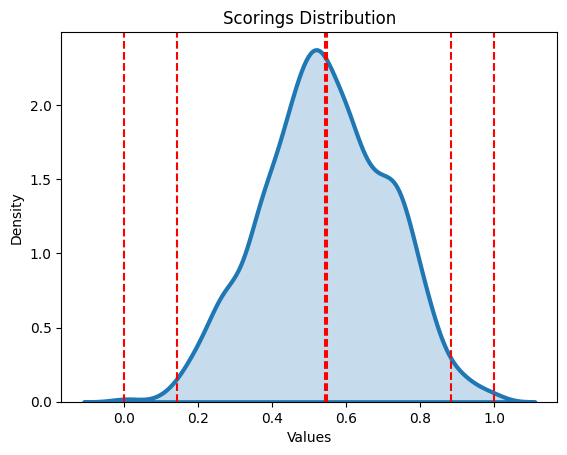

In [ ]:
valores = [min(lmin),min(mean),np.median(median),np.mean(mean),max(mean), max(lmax)]
sns.kdeplot(l_scores, fill=True, common_norm=False, linewidth=3)
for valor in valores:
    plt.axvline(x=valor, color='red', linestyle='--')

plt.title('Scorings Distribution')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show();